In [7]:
import numpy as np
import numpy.linalg as la
import scipy as sc 
import cvxpy as cp
import matplotlib.pyplot as plt
import csv
import scipy.integrate as integrate
import numpy as np
import numpy.linalg as la
from numpy import cross
from numpy.random import rand
import matplotlib.pyplot as plt
import csv
import scipy as sc
import time

from linear_dynamics_LVLH import propagator_absolute,M_to_LVLH,integrate_matrix,matrix_dynamics,propagator_relative,get_phi

In [8]:
r12 = 384400 # km, distance between primary attractors
mu = 1.215e-2 # no unit, mass parameter of the system
TU = 1/(2.661699e-6) # s, inverse of the relative angular frequency between the two primary attractors
L1x = 0.83691513 # nd, position of the L1 point along the x direction
L2x = 1.15568217 # nd, position of the L2 point along the x direction

In [9]:
file = open("target_chaser_trajectories.csv","r")
reader = csv.reader(file)
data_target = []
data_chaser = []
for lines in reader:
    if lines != []:
        data_target.append(lines[:7])
        data_chaser.append(lines[7:])
        # print(lines)
file.close()

1.552320325274684e-05


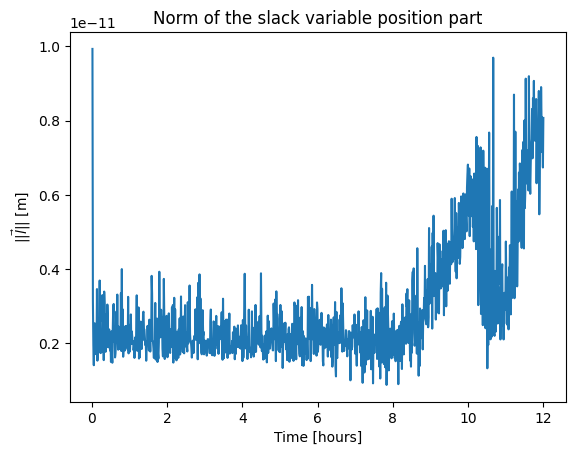

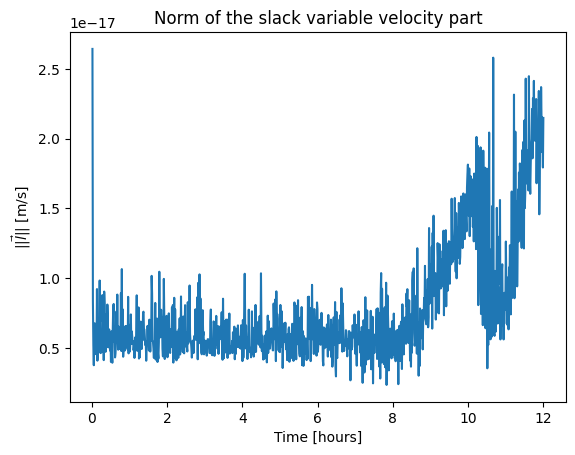

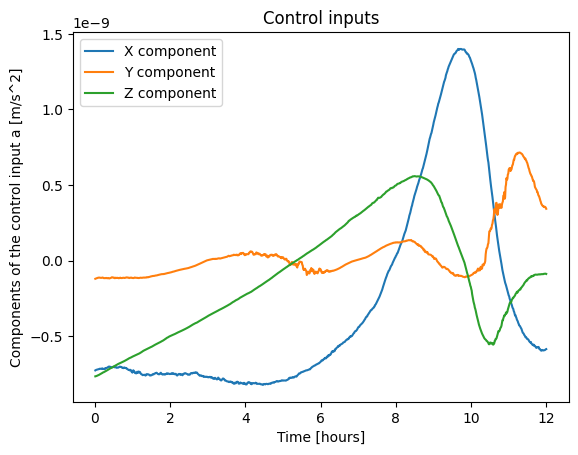

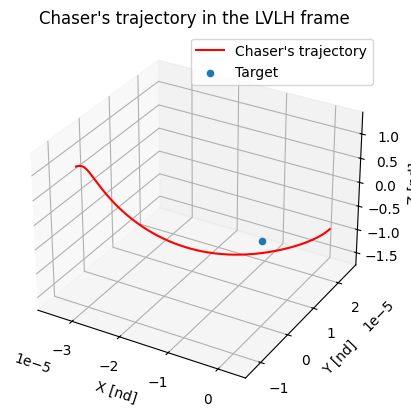

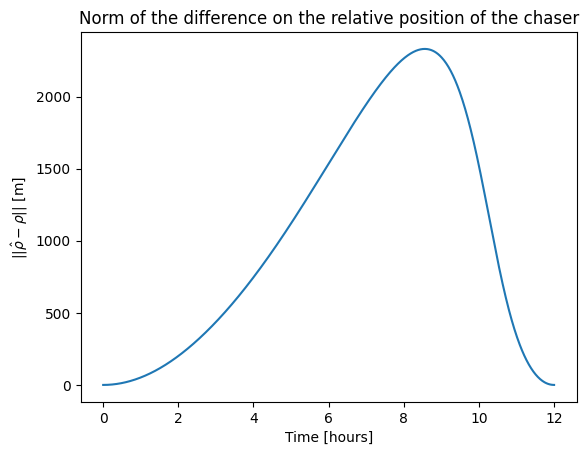

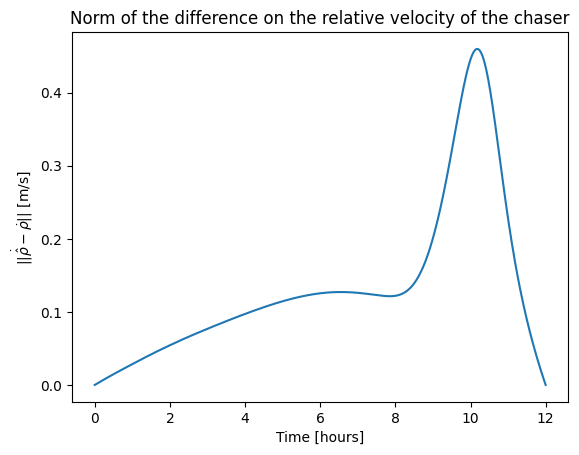

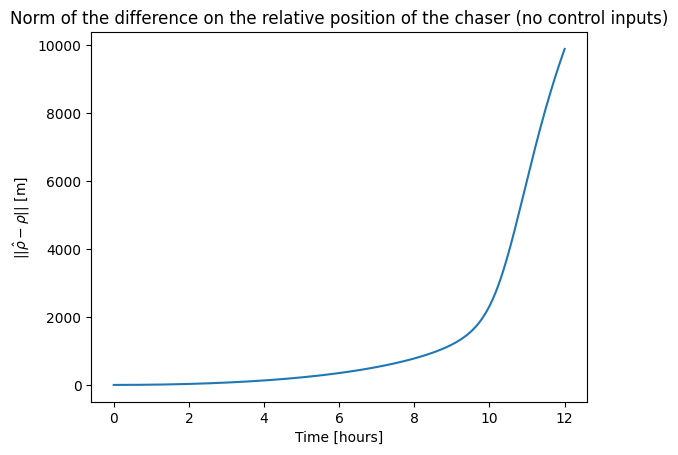

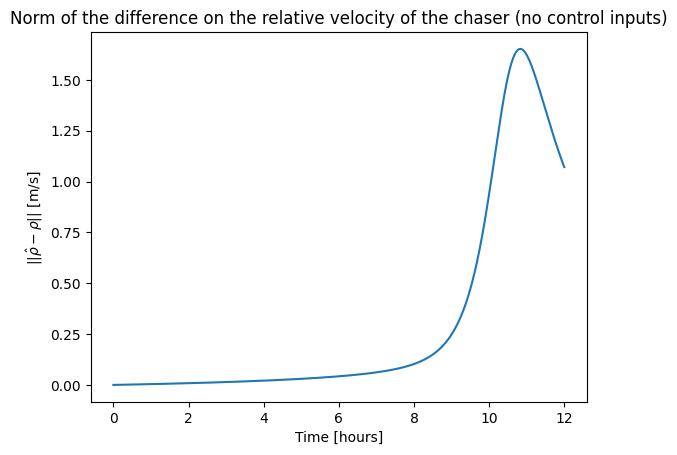

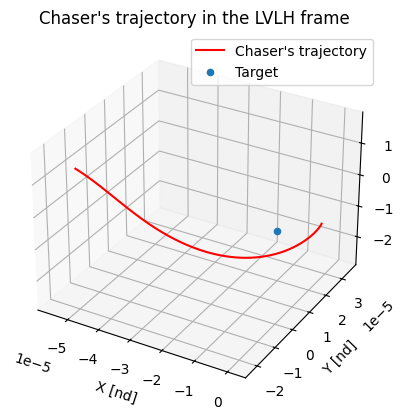

In [10]:
nx = 6 # dimension of the state vector
nu = 3 # dimension of the control input vector
n_time = len(data_target) # number of time steps
s_0,s_f = data_chaser[0],data_chaser[-1] # Do I want to "force" the last state with a slack variable for feasibility or just
# enforce dynamics at each step

# Control input matrix, FOR NOW IT IS CONSTANT
B = np.zeros((6,3))
B[3:,:] = np.eye(3)
# print(B)

# Reformated data
target = np.zeros((len(data_target),len(data_target[0])))
chaser = np.zeros((len(data_chaser),len(data_chaser[0])))
for i in range(len(data_target)):
    # print(data_chaser[i][:])
    target[i] = data_target[i][:]
    chaser[i] = data_chaser[i][:]

# normalized vbariables, working with adimensionalized variables for now
s = cp.Variable((n_time, nx))
l  = cp.Variable((n_time-1, nx))  # slack variable to prevent artificial infeasibility
a = cp.Variable((n_time-1, nu))

# 1st possible optimization problem
con = []
cost = 0
con += [s[0] == s_0]
# con += [s[i+1] == sc.linalg.expm((target[i+1][0]-target[i][0])*matrix_dynamics(target[i,1:],0,mu)) @ s[i] + l[i] for i in range(n_time-1)]
con += [s[i+1] == get_phi(target[i+1][0]-target[i][0],matrix_dynamics(target[i][1:],0,mu)) @ s[i] + B @ a[i] + l[i] for i in range(n_time-1)] # Replace A with the state transition matrix
# con += [s[i+1] == matrix_dynamics(target[i+1][0]-target[i][0],target[i,1:],mu) @ s[i] + l[i] for i in range(n_time-1)]
# con += [s[i+1] == propagator_relative_with_matrix(target[i,1:],target[i+1][0]-target[i][0],mu) @ s[i] + l[i] for i in range(n_time-1)]
con += [s[-1] == s_f]

J = cp.sum(cp.norm(a, 2, axis=0))
cost += J
cost += cp.sum(cp.norm(l, 2, axis=0)) * 1e6   # slack variable penalty

p = cp.Problem(cp.Minimize(cost), con)
p.solve(solver=cp.MOSEK, verbose=False)
s_opt  = s.value # Given the formulation of the STM, should be in the LVLH frame
l_opt  = l.value
a_opt  = a.value
J_opt  = J.value
print(J_opt)

# I'm not sure what are the following variables/parameters 
# status = p.status
# value  = p.value

norm_l_dist = np.zeros(n_time-1)
norm_l_vel = np.zeros(n_time-1)
for l in range(n_time-1):
    norm_l_dist[l] = la.norm(l_opt[l,:3])
    norm_l_vel[l] = la.norm(l_opt[l,3:6])
    
# Plotting the norm of the slack variable (that should be close to 0 since same dynamics)
plt.plot(target[1:,0]*TU/3600,norm_l_dist*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\vec{l}$|| [m]')
plt.title('Norm of the slack variable position part')
plt.show()

plt.plot(target[1:,0]*TU/3600,norm_l_dist*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\vec{l}$|| [m/s]')
plt.title('Norm of the slack variable velocity part')
plt.show()

# Plotting the control inputs over time
plt.plot(target[1:,0]*TU/3600,a_opt[:,0]*r12*1e3/TU**2,label='X component')
plt.plot(target[1:,0]*TU/3600,a_opt[:,1]*r12*1e3/TU**2,label='Y component')
plt.plot(target[1:,0]*TU/3600,a_opt[:,2]*r12*1e3/TU**2,label='Z component')
plt.xlabel('Time [hours]')
plt.ylabel(r'Components of the control input a [m/s^2]')
plt.title('Control inputs')
plt.legend()
plt.show()

# Plotting the optimized trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(s_opt[:,0], s_opt[:,1], s_opt[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

# Comparing the trajectory gotten by optimization and the one gotten with my implementation of the dynamics
# i.e. the main errors should be caused by the discretization of the equations od the chaser's dynamics
error_history = np.zeros(n_time)
error_vel_history = np.zeros(n_time)
for i in range(n_time):
    error = la.norm(chaser[i,:3] - s_opt[i,:3])
    error_history[i] = error
    error_vel_history[i] = la.norm(chaser[i,3:6] - s_opt[i,3:6])
    
plt.plot(target[:,0]*TU/3600,error_history*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\hat{\rho} - \rho$|| [m]')
plt.title('Norm of the difference on the relative position of the chaser')
plt.show()

plt.plot(target[:,0]*TU/3600,error_vel_history*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\dot{\hat{\rho}} - \dot{\rho}$|| [m/s]')
plt.title('Norm of the difference on the relative velocity of the chaser')
plt.show()

# 2nd possible optimization problem (which is just state propagation with STM)
s2 = cp.Variable((n_time, nx))

con = []
cost = 0
con += [s2[0] == s_0]
# con += [s2[i+1] == get_phi(target[i+1][0]-target[i][0],matrix_dynamics(target[i][1:],mu)) @ s2[i] for i in range(n_time-1)] # Replace A with the state transition matrix
# con += [s2[i+1] == matrix_dynamics(target[i+1][0]-target[i][0],target[i,1:],mu) @ s2[i] for i in range(n_time-1)]
con += [s2[i+1] == sc.linalg.expm((target[i+1][0]-target[i][0])*matrix_dynamics(target[i,1:],0,mu)) @ s2[i] for i in range(n_time-1)]


p2 = cp.Problem(cp.Minimize(cost), con)
p2.solve(solver=cp.MOSEK, verbose=False)
s_opt2  = s2.value # Given the formulation of the STM, should be in the LVLH frame
status2 = p2.status
value2  = p2.value

# Comparing the trajectory gotten by optimization and the non-linear dynamics
error_history = np.zeros(n_time)
error_vel_history = np.zeros(n_time)
for i in range(n_time):
    error = la.norm(chaser[i,:3] - s_opt2[i,:3])
    error_history[i] = error
    error_vel_history[i] = la.norm(chaser[i,3:6] - s_opt2[i,3:6])
    
plt.plot(target[:,0]*TU/3600,error_history*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\hat{\rho} - \rho$|| [m]')
plt.title('Norm of the difference on the relative position of the chaser (no control inputs)')
plt.show()

plt.plot(target[:,0]*TU/3600,error_vel_history*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r'||$\hat{\rho} - \rho$|| [m/s]')
plt.title('Norm of the difference on the relative velocity of the chaser (no control inputs)')
plt.show()

# Plotting the optimized trajectory
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(s_opt2[:,0], s_opt2[:,1], s_opt2[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()